In [30]:
# %matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 1

import os
import re
import glob
import pandas as pd
import numpy as np
import numpy.lib.recfunctions as rf
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist

from ipywidgets import interactive, interactive_output, interact_manual

import ipywidgets as widgets
# import cv2
import time
import mediapy
import torch
from tqdm.notebook import tqdm
mpl.rcParams['figure.figsize'] = [16.0, 12.0]

# %aimport plot_functions, seqslam_tools
# from seqslam_tools import seqSLAM_from_distMat, seqSLAM_from_distMatGPU, seqSLAM_from_distMatGPU_multi, seqSLAM_from_distMatGPU_multi_precomputed
# from plot_functions import compare_images_triple, plot_image_on_ax, getPRCurveWrapper, getPRCurveWrapperFromScores, getPAt100R, getPAt100RFromPRVals, getRAtXPFromPRVals

import seaborn as sns; sns.set(); sns.set_style("whitegrid"); sns.set_context("notebook")
# import seaborn_image as isns; isns.set_context("notebook"); isns.set_image(origin="upper")

import tonic
import tonic.transforms as transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
qcr_traverses = [
    'bags_2021-08-19-08-25-42_denoised.feather', # S11 side-facing, slow
    'bags_2021-08-19-08-28-43_denoised.feather', # S11 side-facing, slow
    'bags_2021-08-19-09-45-28_denoised.feather'#, # S11 side-facing, slow
]
traverses_to_compare = qcr_traverses[0:2] #list of filenames
time_windows_overwrite = {  # roughly normalise time windows for traverses where robot was going faster
    'bags_2021-08-20-10-19-45': 1e6*0.4,
    'bags_2021-10-26-15-56-15': 1e6*0.4,
}


path_to_qcr_event_files = '../Data/' # '/media/tobias/storageSSD/qcr-event-zips/'

event_streams = [] #list of len 2 with qry and ref dataframes in each
for traverse in tqdm(traverses_to_compare):
    print(traverse)
    event_streams.append(pd.read_feather(os.path.join(path_to_qcr_event_files, traverse)))

# print(type(event_streams[0]))
# print(event_streams[0])

im_width, im_height = int(event_streams[0]['x'].max() + 1), int(event_streams[0]['y'].max() + 1)

ordering = "txyp"
polarity = 2 #polarity dimension size

x_index = ordering.find("x")
y_index = ordering.find("y")
t_index = ordering.find("t")
p_index = ordering.find("p")

sensor_size = (im_width, im_height, polarity)
print(sensor_size)

# Print durations of traverses
for event_stream in event_streams:
    print((event_stream.iloc[-1]['t'] - event_stream.iloc[0]['t']) / 1e6)

# event_streams_numpy = [event_stream.to_numpy(np.uint64) for event_stream in event_streams] #converts dataframe to numpy array
# print(event_streams_numpy[0].shape)

  0%|          | 0/2 [00:00<?, ?it/s]

bags_2021-08-19-08-25-42_denoised.feather
bags_2021-08-19-08-28-43_denoised.feather
(346, 260, 2)
167.191164
164.199562


In [13]:
#event_frames shape for qry and ref - (164, 2, 346, 260) - [:,0,:,:] - pos events - [:,1,:,:] - neg events
# print(event_streams_numpy[0][0])
sensor_size = (346, 260,2)
# test = tonic.functional.to_frame_numpy(event_streams_numpy[0], sensor_size, ordering, time_window = 1e6)#,ordering,time_window=1e6)


In [19]:
typ = [('t', np.uint64), ('x', np.uint64), ('y', np.uint64), ('p', np.uint64)]
event_frames_np = [rf.unstructured_to_structured(event_stream.to_numpy(np.uint64), dtype=np.dtype(typ)) for event_stream in event_streams]

event_frames = [tonic.functional.to_frame_numpy(event_stream_numpy, sensor_size,
                                                time_window=1e6,
                                                # overlap=time_windows_overwrite.get(traverse, 1e6) * 9 / 10,
                                                ) for traverse, event_stream_numpy in zip(traverses_to_compare, event_frames_np)]

                                                # event_frames.append(tonic.functional.to_frame_numpy(event_stream_np, sensor_size, time_window=1e6))


event_frames_pos = [event_frame[:, 0, :, :] for event_frame in event_frames]
event_frames_neg = [event_frame[:, 1, :, :] for event_frame in event_frames]
event_frames_total = [event_frame_pos + event_frame_neg for event_frame_pos, event_frame_neg in zip(event_frames_pos, event_frames_neg)]
print(event_frames_total[0].shape)       

(167, 260, 346)


In [20]:
# Get them synced
#get rid of small differences in offsets
def get_short_traverse_name(traverse_name):
    m=re.search(r'(\d)[^\d]*$', traverse_name)
    traverse_short = traverse_name[:m.start()+1]
    return traverse_short

event_frames_total_cropped = []
for event_frames, name in zip(event_frames_total, traverses_to_compare):
    short_name = get_short_traverse_name(name)
    if short_name == 'bags_2021-10-21-10-32-55':
        event_frames_total_cropped.append(event_frames[:165])
    elif short_name == 'bags_2021-08-19-08-25-42' or short_name == 'bags_2021-08-19-09-45-28':
        event_frames_total_cropped.append(event_frames[2:166])
    else:
        event_frames_total_cropped.append(event_frames)
[e.shape for e in event_frames_total_cropped]

[(164, 260, 346), (164, 260, 346)]

In [21]:
thresh = 15

print(np.count_nonzero(event_frames_total_cropped[0][event_frames_total_cropped[0] > 10]))
print(np.count_nonzero(event_frames_total_cropped[0][event_frames_total_cropped[0] < 10]) / np.count_nonzero(event_frames_total_cropped[0][event_frames_total_cropped[0] > 10]))

event_frames_total_thresh = np.copy(event_frames_total_cropped)
event_frames_total_thresh[0][event_frames_total_thresh[0] > thresh] = thresh
event_frames_total_thresh[1][event_frames_total_thresh[1] > thresh] = thresh
print(event_frames_total_thresh[0].shape)

656120
10.45092056331159
(164, 260, 346)


(164, 260, 346)
(164, 260, 346)


(0.0, 1000000.0)

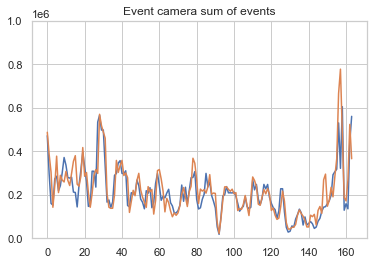

In [22]:
%matplotlib inline
plt.figure()
plt.title('Event camera sum of events')

for event_frame_total in event_frames_total_thresh:
    print(event_frame_total.shape)
    plt.plot(np.arange(len(event_frame_total)), event_frame_total.sum(axis=(1,2)))
plt.ylim(0, 1e6)

<AxesSubplot:title={'center':'Event camera mean of events'}>

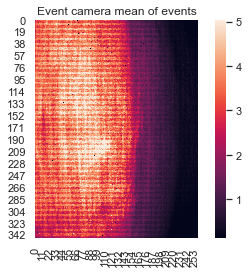

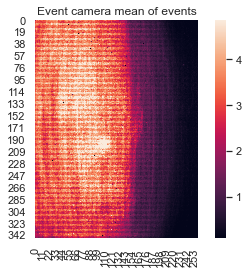

In [23]:
event_means = [event_frame_total.mean(axis=0) for event_frame_total in event_frames_total_thresh]
plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[1].T, robust=True, square=True, cbar=True)

plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[0].T, robust=True, square=True, cbar=True)

(260, 346)
25468
[25468 21518 26406 ... 85066 87874 89959]
(73, 210)
(164, 260, 346)
(164, 260, 346)


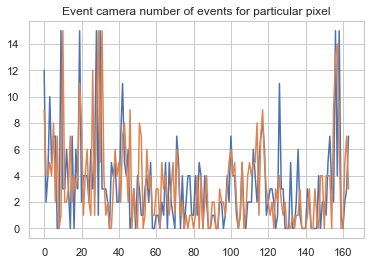

In [24]:
print(event_means[0].shape)
print(np.argmax(event_means[0]))
print(np.argsort(event_means[0], axis = None)[::-1])
print(np.unravel_index(np.argmax(event_means[0]), event_means[0].shape))

top_pixels = np.argsort(event_means[0], axis = None)[::-1]
# Single pixel
plt.figure()
plt.title('Event camera number of events for particular pixel')

for event_frame_total in event_frames_total_thresh:
    plt.plot(np.arange(len(event_frame_total)), event_frame_total[:, 120, 259])
    print(event_frame_total.shape)

In [25]:
print(event_frames_total_thresh[0].shape)

(164, 260, 346)


  0%|          | 0/1000 [00:00<?, ?it/s]

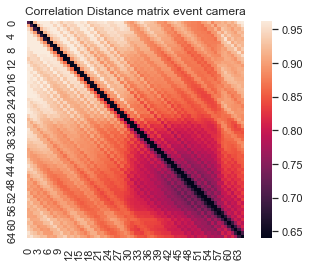

In [26]:


filter_size=100
number_of_pixels=1000
correlation_method = 'diff'

total_number_pixels = event_frames_total_thresh[0].shape[1]*event_frames_total_thresh[0].shape[2]
dmat_cumulative = np.zeros((len(event_frames_total_thresh[0])-filter_size+1,len(event_frames_total_thresh[0])-filter_size+1))

arr = np.arange(total_number_pixels)
np.random.shuffle(arr) #random selection of pixels
# arr = top_pixels

# dmat_cumulative = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))

for pixel_ind in tqdm(arr[0:number_of_pixels]):

    x_pix, y_pix = np.unravel_index(pixel_ind, event_means[0].shape)
    ref = event_frames_total_thresh[0][:,x_pix,y_pix]
    qry = event_frames_total_thresh[1][:,x_pix,y_pix]

    dmat = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))
    for filter_ind in np.arange(len(ref)-filter_size+1):
        filter = qry[filter_ind:filter_ind+filter_size]
        corr = np.correlate(ref, filter)
        corr_norm = corr / np.max(corr)

        corr_diff = np.zeros(corr.shape)
        for idx in np.arange(len(corr_diff)):
            corr_diff[idx] = np.sum(np.abs(ref[idx:idx+filter_size] - filter))
        corr_diff_norm = corr_diff / np.max(corr_diff)
        if correlation_method == "diff":
            dmat[:,filter_ind] = corr_diff #or corr
        else:
            dmat[:,filter_ind] = corr #or corr
        
    dmat_cumulative += dmat
dmat_cumulative /= np.max(dmat_cumulative)

if correlation_method == "corr":
    dmat_cumulative = 1-dmat_cumulative

sns.heatmap(dmat_cumulative, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix event camera')

np.savez("dMats/dMat_test.npz", dMat=dmat_cumulative)

(164, 260, 346)
(164, 89960)


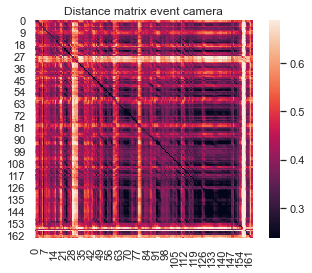

In [27]:

ref_traverse = 0
query_traverse = 1
print(event_frames_total_thresh[ref_traverse].shape)
ref_vec = event_frames_total_thresh[ref_traverse].reshape(event_frames_total_thresh[ref_traverse].shape[0], -1)
qry_vec = event_frames_total_thresh[query_traverse].reshape(event_frames_total_thresh[query_traverse].shape[0], -1)
dMat = cdist(ref_vec, qry_vec ,'euclidean')
dMat /= np.max(dMat)
print(ref_vec.shape)

plt.figure()
sns.heatmap(dMat, robust=True, square=True, cbar=True)
_ = plt.title('Distance matrix event camera')

np.savez("dMats/dMat_test2.npz", dMat=dMat)


In [28]:
prob_to_draw_from = np.copy(event_means[0])
# prob_to_draw_from[np.logical_and(prob_to_draw_from < 0.5, prob_to_draw_from != 0.0)] = 0.01

# Set low prob for "hot pixels"
prob_to_draw_from[prob_to_draw_from > (event_means[0].mean() + 2*event_means[0].std())] = 0.01
prob_sum = prob_to_draw_from.sum()
prob_to_draw_from = prob_to_draw_from / prob_sum

recall_dict = {}
used_pixels_dict = {}
use_saliency = True

seq_length = 15
maxLocRad = 4
gt_tolerance = maxLocRad
precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

num_trials = 15

num_target_pixels_list = [1, 2, 5, 10, 20, 50, 100, 150, 200, 250]
# num_target_pixels_list = [8]

for num_target_pixels in tqdm(num_target_pixels_list):
    if num_target_pixels in recall_dict:
        tqdm.write('skip')
        continue

    recall_dict[num_target_pixels] = []
    used_pixels_dict[num_target_pixels] = []

    for _ in range(num_trials):
        target_pixels = []
        while len(target_pixels) < num_target_pixels:
            random_idx_flat = np.random.choice(np.arange(0, im_height*im_width), p=prob_to_draw_from.reshape(-1) if use_saliency else None)
            random_pixel = np.unravel_index(random_idx_flat, (im_height, im_width))
            if len(target_pixels) == 0 or np.all(np.linalg.norm(np.array(target_pixels) - np.array(random_pixel), axis=1) > 3):
                target_pixels.append(random_pixel)

        # target_pixels_x = np.array([100, 100, 100, 100, 100, 100, 100, 100])
        # target_pixels_y = np.array([0,   25,  50,  75, 100, 125, 150, 175])
        # target_pixels = np.vstack((target_pixels_x, target_pixels_y)).T

        dist_matrices = []
        for target_pixel in target_pixels:
            count_traverse_ref = torch.from_numpy(event_frames_total_cropped[0][:, target_pixel[1], target_pixel[0]].astype(np.float32)).unsqueeze(0)
            count_traverse_qry = torch.from_numpy(event_frames_total_cropped[1][:, target_pixel[1], target_pixel[0]].astype(np.float32)).unsqueeze(0)
            dist_matrix_single = torch.abs(count_traverse_ref.unsqueeze(2) - count_traverse_qry.unsqueeze(1)).to('cpu').type(torch.FloatTensor).unsqueeze(0).squeeze(-1)
            dist_matrices.append(dist_matrix_single)

        dist_matrices_stacked = torch.stack(dist_matrices)
        dist_matrices_summed = torch.mean(dist_matrices_stacked, 0)
        # seq_ret = seqSLAM_from_distMatGPU_multi_precomputed(dist_matrices_summed, precomputed_convWeight)
        # dist_matrix_seqslam = torch.nn.functional.conv2d(dist_matrices_summed, precomputed_convWeight).squeeze()
        # match_indices = seq_ret.indices.to('cpu').detach().numpy()
        # match_scores = seq_ret.values.to('cpu').detach().numpy()
        # # print(f'combined P@100R: {getPAt100R(match_indices, maxLocRad)[-1]:.2f}')

        # prvals = getPRCurveWrapperFromScores(match_indices, match_scores, gt_tolerance)

        # match_scores_revised = np.empty(match_scores.shape, dtype=np.float32)
        # for query in range(len(dist_matrix_seqslam)):
        #     refs_sorted = dist_matrix_seqslam[query].argsort()
        #     best_match = refs_sorted[0]
        #     second_best_match = refs_sorted[torch.abs(refs_sorted - best_match) >= 3][0]
        #     match_scores_revised[query] = dist_matrix_seqslam[query][best_match] / dist_matrix_seqslam[query][second_best_match]

        # prvals_revised = getPRCurveWrapperFromScores(match_indices, match_scores_revised, gt_tolerance)
        # # tqdm.write(f'combined R@99P: {getRAtXPFromPRVals(prvals_revised, 0.99):.2f}')

        # recall_dict[num_target_pixels].append(getRAtXPFromPRVals(prvals_revised, 0.99))
        # used_pixels_dict[num_target_pixels].append(target_pixels)

    mean_recall = np.mean(recall_dict[num_target_pixels])
    median_recall = np.median(recall_dict[num_target_pixels])
    # tqdm.write(f'mean R@99P: {mean_recall:.2f}; median R@99P: {median_recall:.2f}; worst R@99P: {np.array(recall_dict[num_target_pixels]).min():.2f}; best R@99P: {np.array(recall_dict[num_target_pixels]).max():.2f}')


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: index 284 is out of bounds for axis 1 with size 260

(20,)
max correlation index: 0
truth correlation index: 0
[ 5  4  0  0 10  5  3  1  4  1  6  1  3 11 14 11  1  2  9  6]
[ 6  0  6  7 10  2  1  0  4  5 12  4 11 15  7  4  2  6  6 10]
(145, 145)
(164,)


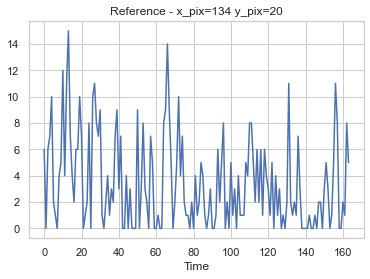

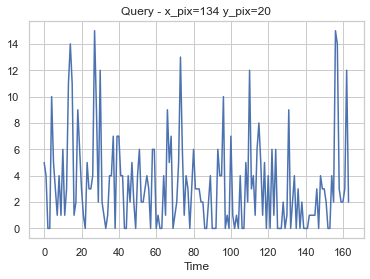

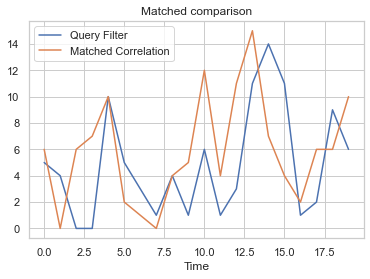

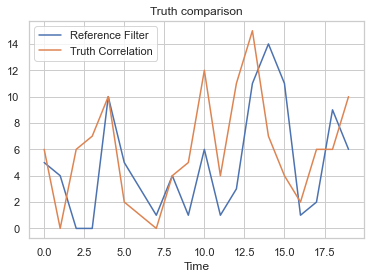

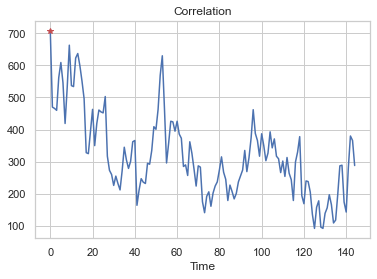

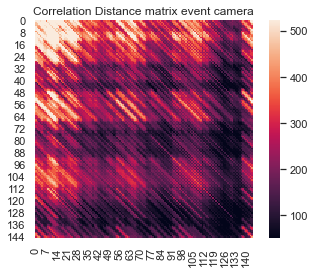

In [29]:

x_pix = 134
y_pix = 20

# x_pix = 120
# y_pix = 259

ref = event_frames_total_thresh[0][:,x_pix,y_pix]
# print(event_frames_total_cropped[0].shape)
# print(ref.shape)
qry = event_frames_total_thresh[1][:,x_pix,y_pix]

filter_size = 20

filter_ind = 0
filter = qry[filter_ind:filter_ind+filter_size]
print(filter.shape)
corr = np.correlate(ref, filter)
max_corr = np.max(corr)
max_corr_ind = np.where(corr==max_corr)[0][0]
print("max correlation index: " + str(max_corr_ind))
print("truth correlation index: " + str(filter_ind))

i = max_corr_ind
print(filter)
print(ref[i:i+filter_size])

plt.figure()
plt.title("Reference - x_pix=" + str(x_pix) + " y_pix=" + str(y_pix))
plt.plot(np.arange(len(ref)), ref)
plt.xlabel("Time")

plt.figure()
plt.title("Query - x_pix=" + str(x_pix) + " y_pix=" + str(y_pix))
plt.plot(np.arange(len(qry)), qry)
plt.xlabel("Time")

plt.figure()
plt.title("Matched comparison")
plt.plot(np.arange(filter_size), filter)
plt.plot(np.arange(filter_size), ref[i:i+filter_size])
plt.legend(["Query Filter", "Matched Correlation"])
plt.xlabel("Time")

plt.figure()
plt.title("Truth comparison")
plt.plot(np.arange(filter_size), filter)
plt.plot(np.arange(filter_size), ref[filter_ind:filter_ind+filter_size])
plt.legend(["Reference Filter", "Truth Correlation"])
plt.xlabel("Time")

plt.figure()
plt.title("Correlation")
plt.plot(np.arange(len(corr)), corr)
plt.plot(max_corr_ind, max_corr, 'r*')
plt.xlabel("Time")

dmat_corr = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))
print(dmat_corr.shape)
print(ref.shape)
for filter_ind in np.arange(len(ref)-filter_size+1):
    filter = qry[filter_ind:filter_ind+filter_size]
    corr = np.correlate(ref, filter)

    corr_diff = np.zeros(corr.shape)
    for idx in np.arange(len(corr_diff)):
        corr_diff[idx] = np.sum(np.abs(ref[idx:idx+filter_size] - filter))
    corr_norm = corr / np.max(corr)
    corr_diff_norm = corr_diff / np.max(corr_diff)
    dmat_corr[:,filter_ind] = corr

plt.figure()
sns.heatmap(dmat_corr, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix event camera')